In [1]:
import sys, os
sys.path.append(os.getcwd())  # so we can import src/* and config/*


In [2]:
from config import settings
from src.pipeline import run_download, run_process, run_build_splits, run_materialize_folds, run_baseline
from src.viz.plots import (
    collect_metrics, plot_metric_bars, plot_cum_pnl,
    plot_pred_vs_true, plot_residual_hist, plot_lastN_ts,
    results_to_df
)

In [3]:
res = run_download()
print("Downloaded datasets:")
for r in res:
    print(f" - {r['symbol']:>8} | {r['rows']:>5} rows | {r['start']} → {r['end']} | {r['path']}")

Downloaded datasets:
 -    ^GSPC |  5049 rows | 2005-09-21 → 2025-10-15 | data/raw/GSPC_2005-09-21_to_2025-10-16_1d.csv
 -      SPY |  5049 rows | 2005-09-21 → 2025-10-15 | data/raw/SPY_2005-09-21_to_2025-10-16_1d.csv
 -  BTC-USD |  4047 rows | 2014-09-17 → 2025-10-15 | data/raw/BTC-USD_2005-09-21_to_2025-10-16_1d.csv
 -  ETH-USD |  2898 rows | 2017-11-09 → 2025-10-15 | data/raw/ETH-USD_2005-09-21_to_2025-10-16_1d.csv
 -    ^NSEI |  4435 rows | 2007-09-17 → 2025-10-15 | data/raw/NSEI_2005-09-21_to_2025-10-16_1d.csv
 - ^NSEBANK |  4160 rows | 2007-09-17 → 2025-10-15 | data/raw/NSEBANK_2005-09-21_to_2025-10-16_1d.csv
 - RELIANCE.NS |  4950 rows | 2005-09-21 → 2025-10-15 | data/raw/RELIANCE.NS_2005-09-21_to_2025-10-16_1d.csv
 -   TCS.NS |  4950 rows | 2005-09-21 → 2025-10-15 | data/raw/TCS.NS_2005-09-21_to_2025-10-16_1d.csv
 - EURUSD=X |  5205 rows | 2005-09-22 → 2025-10-15 | data/raw/EURUSD=X_2005-09-21_to_2025-10-16_1d.csv
 - USDINR=X |  5203 rows | 2005-09-22 → 2025-10-15 | data/raw/US

In [3]:
proc_paths = run_process()
proc_paths

/Users/pep/Desktop/esn-finance/src/data/loader.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index, errors="coerce")
/Users/pep/Desktop/esn-finance/src/data/loader.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index, errors="coerce")


{'GSPC': 'data/processed/GSPC_features.csv',
 'SPY': 'data/processed/SPY_features.csv'}

In [4]:
folds = run_build_splits(proc_paths)
print(f"Built {len(folds)} folds. Example fold[0]: {folds[0] if folds else '—'}")

Built 9 folds. Example fold[0]: {'train': {'start': '2005-12-14', 'end': '2015-12-18'}, 'test': {'start': '2015-12-21', 'end': '2016-12-19'}, 'details': {'train_days': 2520, 'test_days': 252}}


In [5]:
run_materialize_folds(proc_paths, folds)
print("Materialized folds in:", settings.SPLIT_DIR)

Materialized folds in: data/splits


### Main model

In [6]:
result_esn = run_baseline(model_name="esn", fold_id=0, horizon="target_h1")

### Baselines

In [7]:
# Simple linear projection head
result_linear_projection = run_baseline(model_name="ridge", fold_id=0, horizon="target_h1")

# LSTM (32-step window)
result_lstm = run_baseline(model_name="lstm", fold_id=0, horizon="target_h1")

# Transformer (causal)
result_tf = run_baseline(model_name="transformer", fold_id=0, horizon="target_h1")

# Temporal ConvNet
result_tcn = run_baseline(model_name="tcn", fold_id=0, horizon="target_h1")

/Users/pep/Desktop/esn-finance/src/models/lstm.py:99: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  ds = TensorDataset(torch.from_numpy(Xa), torch.from_numpy(Ya))


In [8]:
print(result_esn)
print(result_linear_projection)
print(result_lstm) 
print(result_tf)
print(result_tcn)

{'model': 'esn', 'fold': 0, 'horizon': 'target_h1', 'rmse': 0.010097866116891986, 'mae': 0.007851897859174964, 'r2': -0.4753781004994253, 'dir_acc': 0.5277777777777778, 'backtest': {'avg_daily_pnl': 0.000840630933736941, 'vol': 0.00827769615774013, 'sharpe': 1.612, 'hit_ratio': 0.528, 'turnover': 0.853}}
{'model': 'ridge', 'fold': 0, 'horizon': 'target_h1', 'rmse': 0.008334989760116741, 'mae': 0.005988647394107663, 'r2': -0.0052041142517864625, 'dir_acc': 0.49206349206349204, 'backtest': {'avg_daily_pnl': 7.716786655492856e-05, 'vol': 0.008323154583849718, 'sharpe': 0.147, 'hit_ratio': 0.492, 'turnover': 0.687}}
{'model': 'lstm', 'fold': 0, 'horizon': 'target_h1', 'rmse': 0.009392311966999916, 'mae': 0.0070250805692818824, 'r2': -0.27640687530345653, 'dir_acc': 0.5079365079365079, 'backtest': {'avg_daily_pnl': 0.00020755933712792392, 'vol': 0.008324637541240517, 'sharpe': 0.396, 'hit_ratio': 0.508, 'turnover': 0.337}}
{'model': 'transformer', 'fold': 0, 'horizon': 'target_h1', 'rmse': 

,model,fold,horizon,rmse,mae,r2,dir_acc,avg_daily_pnl,vol,sharpe,hit_ratio,turnover
0,ridge,0,target_h1,0.008335,0.005989,-0.005204,0.492063,0.000077,0.008323,0.147,0.492,0.687
1,lstm,0,target_h1,0.009392,0.007025,-0.276407,0.507937,0.000208,0.008325,0.396,0.508,0.337
2,esn,0,target_h1,0.010098,0.007852,-0.475378,0.527778,0.000841,0.008278,1.612,0.528,0.853
3,transformer,0,target_h1,0.014366,0.011092,-1.986377,0.480159,-0.000127,0.008332,-0.242,0.480,0.456
4,tcn,0,target_h1,0.028566,0.019333,-10.806946,0.551587,0.000433,0.008313,0.826,0.552,0.631


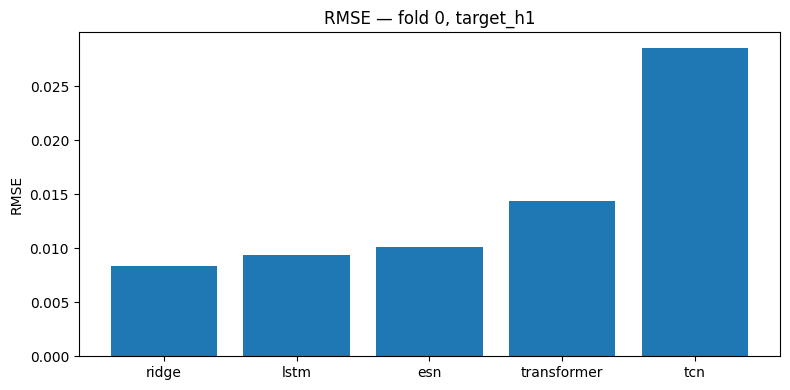

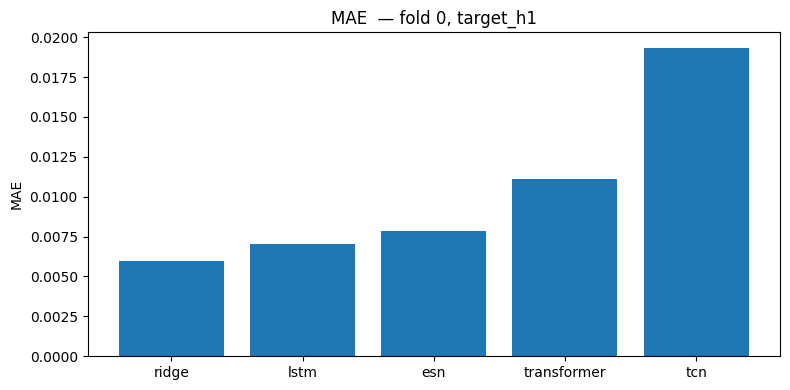

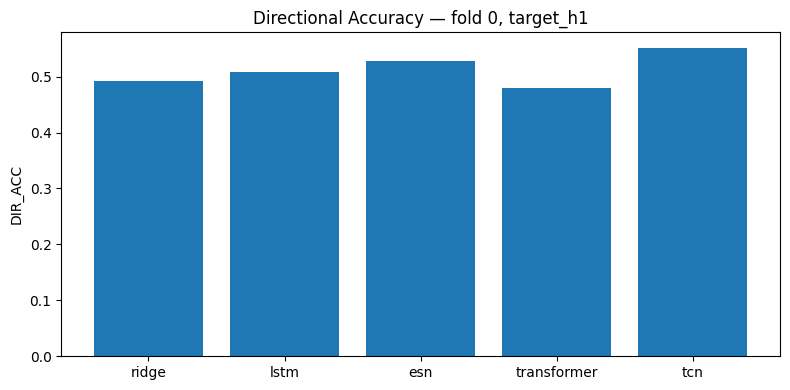

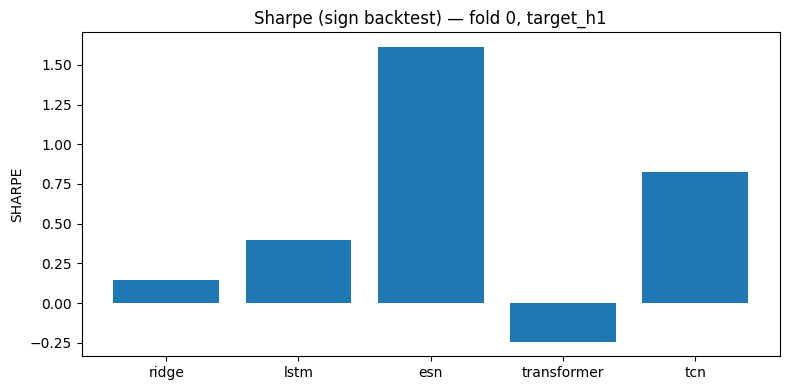

In [10]:
models = ["ridge", "esn", "lstm", "transformer", "tcn"]  # must match registry keys
fold_id = 0
horizon = "target_h1"

dfm = collect_metrics(models, fold_id, horizon)
display(dfm)  # table

# Bar charts
plot_metric_bars(dfm, metric="rmse", title=f"RMSE — fold {fold_id}, {horizon}")
plot_metric_bars(dfm, metric="mae",  title=f"MAE  — fold {fold_id}, {horizon}")
plot_metric_bars(dfm, metric="dir_acc", title=f"Directional Accuracy — fold {fold_id}, {horizon}")
plot_metric_bars(dfm, metric="sharpe", title=f"Sharpe (sign backtest) — fold {fold_id}, {horizon}")

# Tests on longer horizons

In [7]:
result_h5 = run_baseline(model_name="ridge", fold_id=0, horizon="target_h5")
result_h5

{'model': 'ridge',
 'fold': 0,
 'horizon': 'target_h5',
 'rmse': 0.018029446305257376,
 'mae': 0.013631059340556263,
 'r2': -0.05122991240156738,
 'dir_acc': 0.44841269841269843,
 'backtest': {'avg_daily_pnl': -0.002098181846105881,
  'vol': 0.017626862432496188,
  'sharpe': -1.89,
  'hit_ratio': 0.448,
  'turnover': 0.425}}

In [8]:
result_h20 = run_baseline(model_name="ridge", fold_id=0, horizon="target_h20")
result_h20

{'model': 'ridge',
 'fold': 0,
 'horizon': 'target_h20',
 'rmse': 0.033855047552795926,
 'mae': 0.026869790311605878,
 'r2': -0.23131916868042324,
 'dir_acc': 0.4365079365079365,
 'backtest': {'avg_daily_pnl': -0.004383155235672191,
  'vol': 0.03261528428941353,
  'sharpe': -2.133,
  'hit_ratio': 0.437,
  'turnover': 0.425}}